In [8]:
pip install ase

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

/home/robert/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
Strut = read("Ag_344.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]
Struct = structures.struct(2.88, g, m)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 344/344 dipoles valid


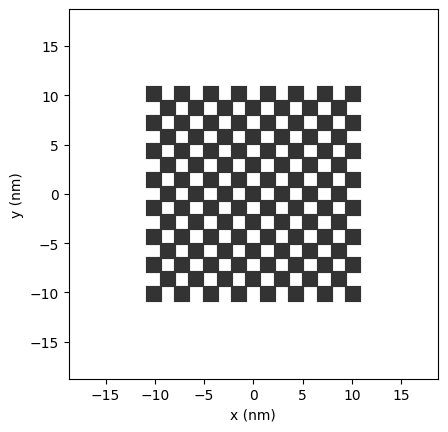

In [3]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)
kwargs = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2])    # LCP, RCP
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

dyads = propagators.DyadsQuasistatic123(n1=1)
sim = core.simulation(Struct, efield, dyads)

visu.structure(sim, projection="xy")

In [4]:
sim.scatter()

/home/robert/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


timing for wl=300.00nm - setup: EE 4251.1ms, inv.: 11219.3ms, repropa.: 6273.9ms (1 field configs), tot: 21744.5ms
timing for wl=302.50nm - setup: EE 25.8ms, inv.: 12053.5ms, repropa.: 8.5ms (1 field configs), tot: 12088.1ms
timing for wl=305.00nm - setup: EE 64.2ms, inv.: 9925.8ms, repropa.: 9.4ms (1 field configs), tot: 9999.8ms
timing for wl=307.50nm - setup: EE 49.3ms, inv.: 8745.0ms, repropa.: 24.6ms (1 field configs), tot: 8819.2ms
timing for wl=310.00nm - setup: EE 39.4ms, inv.: 6747.5ms, repropa.: 8.4ms (1 field configs), tot: 6795.8ms
timing for wl=312.50nm - setup: EE 39.6ms, inv.: 13701.7ms, repropa.: 16.1ms (1 field configs), tot: 13757.6ms
timing for wl=315.00nm - setup: EE 30.3ms, inv.: 13679.3ms, repropa.: 16.8ms (1 field configs), tot: 13726.5ms
timing for wl=317.50nm - setup: EE 30.2ms, inv.: 10585.1ms, repropa.: 24.3ms (1 field configs), tot: 10639.8ms
timing for wl=320.00nm - setup: EE 46.3ms, inv.: 9897.5ms, repropa.: 11.4ms (1 field configs), tot: 9955.3ms
timing f

1

In [9]:
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}


In [10]:
search_dict = dict(wavelength=400)
idx = tools.get_closest_field_index(sim, search_dict)

print('closest match: index', idx)
print('    --> dict:', sim.E[idx][0])

closest match: index 40
    --> dict: {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966, 'wavelength': 400.0}


In [ ]:
a_ext, a_scat, a_abs = linear.extinct(sim, idx)
print("cross sections:")
print("    extinction = {:.2f} nm^2".format(float(a_ext)))
print("    scattering = {:.2f} nm^2".format(float(a_scat)))
print("    absorption = {:.2f} nm^2".format(float(a_abs)))

TypeError: extinct() missing 1 required positional argument: 'field_index'

In [21]:
wl, spec = tools.calculate_spectrum(sim, 0, linear.extinct)
ex,sc,ab = spec.T

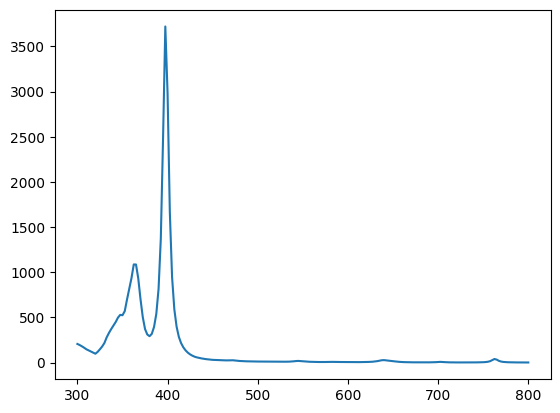

In [23]:
plt.plot(wl, ex, label='extinction')

In [51]:
help(linear.optical_chirality)

Help on function optical_chirality in module pyGDM2.linear:

optical_chirality(sim, field_index, r_probe, which_field='t', **kwargs)
    calculate the optical chirality of the electromagnetic field
    
    ** ------- FUNCTION STILL UNDER TESTING ------- **
    
    Returns the normalized electromagnetic chirality *C / C_LCP*, as defined in [1-4].
    Normalized to a left circular polarized (LCP) plane wave of amplitude |E_0|=1.
    Hence:
    
     --> LCP: C = + 1
     --> RCP: C = - 1
    
    see also [3] or [4] for a short discussion about the normalization to LCP.
    
    |C/C_LCP|>1 means that the local field is "superchiral", 
    hence a chiral molecule is excited with higher selectivity than it would be
    with circular polarized light.
    
    kwargs are passed to :func:`.nearfield`.
    
    Parameters
    ----------
    sim : :class:`.core.simulation`
        simulation description
    
    field_index : int
        index of evaluated self-consistent field to use for ca

In [59]:
## --- calculate the C spectrum at top of the center between rods
Z_probe = 0

## L-dimer
wl, Cspec = tools.calculate_spectrum(sim, 0, linear.optical_chirality, r_probe=[[0,0,Z_probe]])
C_spec_R = Cspec.T

r_probe = tools.generate_NF_map(-30,+30,101, -30,30,101, Z0=Z_probe)

C_R = linear.optical_chirality(sim, idx, r_probe, which_field='0')

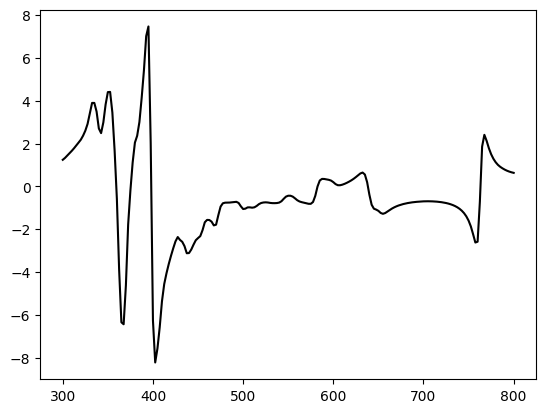

In [56]:
plt.plot(wl, Cspec, color='k', label='L-struct')

In [69]:
C_R[-1]

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

(-30.0, 30.0)

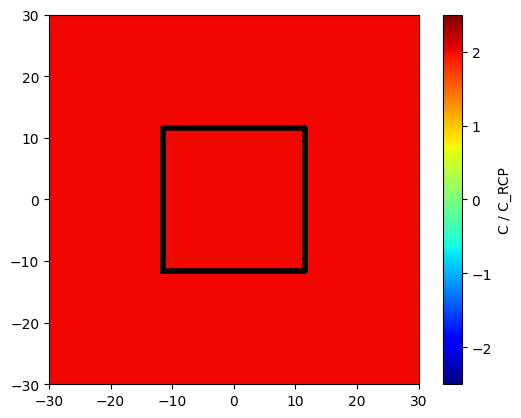

In [61]:
im = visu.scalarfield(C_R, cmap='jet', show=0, interpolation='nearest')

plt.colorbar(im, label='C / C_RCP')
im.set_clim(-2.5, 2.5)
visu.structure_contour(sim, color='k', show=0, lw = 4)
plt.xlim(-30, 30)
plt.ylim(-30, 30)